## Rain prediction in Australia

#### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

import sklearn

from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn.impute import SimpleImputer

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler,OneHotEncoder, LabelEncoder

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, f1_score,ConfusionMatrixDisplay,classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc

import optuna

import xgboost as xgb
from xgboost import XGBClassifier

import joblib

<br>
<br>
<br>
<br>
<br>

#### Read dataset

In [2]:
dataframe_clean_wo_outl_wo_corr = pd.read_csv(r"C:\Users\Lucio\Documents\Github\Next-day-rain-prediction\1- Data\2- Processed\dataframe_clean_wo_outl_wo_corr.csv", index_col=0)
dataframe_clean_wo_outl_wo_corr.head()

,Location,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,Humidity9am,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,Albury,0.6,W,44.0,W,WNW,71.0,22.0,1007.7,0.0,0.0
1,Albury,0.0,WNW,44.0,NNW,WSW,44.0,25.0,1010.6,0.0,0.0
2,Albury,0.0,WSW,46.0,W,WSW,38.0,30.0,1007.6,0.0,0.0
3,Albury,0.0,NE,24.0,SE,E,45.0,16.0,1017.6,0.0,0.0
4,Albury,1.0,W,41.0,ENE,NW,82.0,33.0,1010.8,0.0,0.0


dataframe_clean_wo_outl_wo_corr characteristics:
- Removed univariated outliers
- Removed variables with high collinearity

<br>
<br>
<br>
<br>
<br>

#### Encode Categorical Features

In [3]:
dataframe_encoded = pd.get_dummies(dataframe_clean_wo_outl_wo_corr)
dataframe_encoded.head()

,Rainfall,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,RainToday,RainTomorrow,Location_Adelaide,Location_Albany,Location_Albury,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,0.6,44.0,71.0,22.0,1007.7,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.0,44.0,44.0,25.0,1010.6,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0.0,46.0,38.0,30.0,1007.6,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0.0,24.0,45.0,16.0,1017.6,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1.0,41.0,82.0,33.0,1010.8,0.0,0.0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


<br>
<br>
<br>
<br>
<br>

## Model Tranining

#### Create X and y dataframes

In [4]:
X = dataframe_encoded[[c for c in dataframe_encoded if c != 'RainTomorrow']].values
y = dataframe_encoded[['RainTomorrow']]

In [5]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y,random_state=42, test_size=0.30)

#### Applying StandardScaler

In [6]:
sc_X = MinMaxScaler()
sc_y = MinMaxScaler()
X_sc = sc_X.fit_transform(X)
y_sc = sc_y.fit_transform(y)

In [7]:
X_sc_train, X_sc_val, y_sc_train, y_sc_val = sklearn.model_selection.train_test_split(X_sc, y_sc, random_state=42, test_size=0.30)

#### Applying SMOTE

In [8]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_sc_train, y_train)

<br>
<br>
<br>
<br>
<br>

#### Define optimization function

def objective_xgb(trial):
    param = {
        "verbosity": 1,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        'eval_metric': 'error',
    }

    #param["booster"] == "gbtree"
    param["subsample"] = trial.suggest_float("subsample", 1e-8, 1.0, log=True)
    param["n_estimators"] = trial.suggest_int("n_estimators", 1, 1000)        
    param["max_depth"] = trial.suggest_int("max_depth", 1, 64)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    
    ratio_majority_to_minority = len(y_train[y_train == 0]) / len(y_train[y_train == 1])  #Adjust weights based on rain/no-rain proportion
    
    bst = xgb.XGBClassifier(**param, scale_pos_weight=ratio_majority_to_minority)
    bst.fit(X_train, y_train)

    y_pred = bst.predict(X_val)
    accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)

    return -accuracy  #Negative accuracy to maximize it (because 'eval_metric': 'error')

In [9]:
def objective_xgb(trial):
    param = {
        "verbosity": 1,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        'eval_metric': 'error',
    }

    #param["booster"] == "gbtree"
    param["subsample"] = trial.suggest_float("subsample", 1e-8, 1.0, log=True)
    param["n_estimators"] = trial.suggest_int("n_estimators", 1, 1000)        
    param["max_depth"] = trial.suggest_int("max_depth", 1, 64)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    
    ratio_majority_to_minority = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])  # Ajustar pesos basados en la proporción de lluvia/no-lluvia
    
    bst = xgb.XGBClassifier(**param, scale_pos_weight=ratio_majority_to_minority)
    bst.fit(X_train_resampled, y_train_resampled)

    y_pred = bst.predict(X_sc_val)
    accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)

    return -accuracy  #Negative accuracy (because of 'eval_metric': 'error')

#### Hyperparameter optimization with Optuna

In [10]:
study_xgb = optuna.create_study()
study_xgb.optimize(objective_xgb, n_trials=10) #Suggested n_trials -> 50
study_xgb.best_params

[I 2023-11-25 14:36:35,388] A new study created in memory with name: no-name-506d4a58-8c30-4bca-90ae-534e2546aa7e
[I 2023-11-25 14:38:11,669] Trial 0 finished with value: -0.7535264570288309 and parameters: {'booster': 'gbtree', 'lambda': 0.024925240467446944, 'alpha': 1.773000249691894e-05, 'subsample': 0.027724299070628775, 'n_estimators': 844, 'max_depth': 1, 'eta': 2.5793096276847858e-05, 'gamma': 2.922323474258536e-08, 'grow_policy': 'depthwise'}. Best is trial 0 with value: -0.7535264570288309.
[I 2023-11-25 14:39:20,005] Trial 1 finished with value: -0.7512328264409734 and parameters: {'booster': 'gbtree', 'lambda': 1.4768149112593e-06, 'alpha': 2.2116051880563356e-08, 'subsample': 7.609953083777091e-05, 'n_estimators': 543, 'max_depth': 16, 'eta': 0.017252321856571568, 'gamma': 0.01113531438718499, 'grow_policy': 'depthwise'}. Best is trial 0 with value: -0.7535264570288309.
[I 2023-11-25 15:02:04,971] Trial 2 finished with value: -0.8132067249248836 and parameters: {'booster':

{'booster': 'gbtree',
 'lambda': 2.2823385466809518e-08,
 'alpha': 0.04605887750306568,
 'subsample': 0.3509783079708015,
 'n_estimators': 733,
 'max_depth': 37,
 'eta': 0.003376719357678204,
 'gamma': 0.0006160493771603005,
 'grow_policy': 'depthwise'}

In [11]:
xgb_params = study_xgb.best_params
xgb_params

{'booster': 'gbtree',
 'lambda': 2.2823385466809518e-08,
 'alpha': 0.04605887750306568,
 'subsample': 0.3509783079708015,
 'n_estimators': 733,
 'max_depth': 37,
 'eta': 0.003376719357678204,
 'gamma': 0.0006160493771603005,
 'grow_policy': 'depthwise'}

#### Train model using best parameters

In [13]:
ratio_majority_to_minority = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])  #Ratio to scale_pos_weight parameter

model = XGBClassifier(**xgb_params, silent=0, scale_pos_weight=ratio_majority_to_minority)

model.fit(X_train_resampled, y_train_resampled, eval_set=[(X_sc_val, y_val)], early_stopping_rounds=10, verbose=True)

[16:03:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.69144
[1]	validation_0-logloss:0.68978
[2]	validation_0-logloss:0.68811
[3]	validation_0-logloss:0.68646
[4]	validation_0-logloss:0.68481
[5]	validation_0-logloss:0.68315
[6]	validation_0-logloss:0.68154
[7]	validation_0-logloss:0.67992
[8]	validation_0-logloss:0.67832
[9]	validation_0-logloss:0.67673
[10]	validation_0-logloss:0.67515
[11]	validation_0-logloss:0.67360
[12]	validation_0-logloss:0.67204
[13]	validation_0-logloss:0.67048
[14]	validation_0-logloss:0.66895
[15]	validation_0-logloss:0.66742
[16]	validation_0-logloss:0.66590
[17]	validation_0

[226]	validation_0-logloss:0.47669
[227]	validation_0-logloss:0.47619
[228]	validation_0-logloss:0.47568
[229]	validation_0-logloss:0.47519
[230]	validation_0-logloss:0.47468
[231]	validation_0-logloss:0.47417
[232]	validation_0-logloss:0.47368
[233]	validation_0-logloss:0.47318
[234]	validation_0-logloss:0.47270
[235]	validation_0-logloss:0.47221
[236]	validation_0-logloss:0.47173
[237]	validation_0-logloss:0.47124
[238]	validation_0-logloss:0.47076
[239]	validation_0-logloss:0.47028
[240]	validation_0-logloss:0.46980
[241]	validation_0-logloss:0.46934
[242]	validation_0-logloss:0.46885
[243]	validation_0-logloss:0.46836
[244]	validation_0-logloss:0.46789
[245]	validation_0-logloss:0.46743
[246]	validation_0-logloss:0.46697
[247]	validation_0-logloss:0.46650
[248]	validation_0-logloss:0.46604
[249]	validation_0-logloss:0.46558
[250]	validation_0-logloss:0.46511
[251]	validation_0-logloss:0.46466
[252]	validation_0-logloss:0.46420
[253]	validation_0-logloss:0.46375
[254]	validation_0-l

[461]	validation_0-logloss:0.40258
[462]	validation_0-logloss:0.40240
[463]	validation_0-logloss:0.40222
[464]	validation_0-logloss:0.40205
[465]	validation_0-logloss:0.40187
[466]	validation_0-logloss:0.40168
[467]	validation_0-logloss:0.40151
[468]	validation_0-logloss:0.40134
[469]	validation_0-logloss:0.40116
[470]	validation_0-logloss:0.40099
[471]	validation_0-logloss:0.40081
[472]	validation_0-logloss:0.40064
[473]	validation_0-logloss:0.40047
[474]	validation_0-logloss:0.40030
[475]	validation_0-logloss:0.40013
[476]	validation_0-logloss:0.39996
[477]	validation_0-logloss:0.39979
[478]	validation_0-logloss:0.39963
[479]	validation_0-logloss:0.39945
[480]	validation_0-logloss:0.39929
[481]	validation_0-logloss:0.39913
[482]	validation_0-logloss:0.39895
[483]	validation_0-logloss:0.39877
[484]	validation_0-logloss:0.39859
[485]	validation_0-logloss:0.39844
[486]	validation_0-logloss:0.39827
[487]	validation_0-logloss:0.39810
[488]	validation_0-logloss:0.39794
[489]	validation_0-l

[696]	validation_0-logloss:0.37564
[697]	validation_0-logloss:0.37557
[698]	validation_0-logloss:0.37551
[699]	validation_0-logloss:0.37543
[700]	validation_0-logloss:0.37537
[701]	validation_0-logloss:0.37530
[702]	validation_0-logloss:0.37524
[703]	validation_0-logloss:0.37518
[704]	validation_0-logloss:0.37512
[705]	validation_0-logloss:0.37505
[706]	validation_0-logloss:0.37499
[707]	validation_0-logloss:0.37492
[708]	validation_0-logloss:0.37487
[709]	validation_0-logloss:0.37481
[710]	validation_0-logloss:0.37475
[711]	validation_0-logloss:0.37469
[712]	validation_0-logloss:0.37462
[713]	validation_0-logloss:0.37455
[714]	validation_0-logloss:0.37449
[715]	validation_0-logloss:0.37444
[716]	validation_0-logloss:0.37439
[717]	validation_0-logloss:0.37432
[718]	validation_0-logloss:0.37426
[719]	validation_0-logloss:0.37419
[720]	validation_0-logloss:0.37413
[721]	validation_0-logloss:0.37407
[722]	validation_0-logloss:0.37401
[723]	validation_0-logloss:0.37396
[724]	validation_0-l

XGBClassifier(alpha=0.04605887750306568, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eta=0.003376719357678204,
              eval_metric=None, gamma=0.0006160493771603005, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=2.2823385466809518e-08,
              learning_rate=0.00337671931, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=37, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=733,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

#### Predict using validation dataset

In [14]:
y_predicted = model.predict(X_sc_val)
y_predicted

array([1, 0, 0, ..., 0, 1, 0])

#### Model performance evaluation

In [24]:
conf_matrix = confusion_matrix(y_val, y_predicted)

accuracy = accuracy_score(y_val, y_predicted)
precision = precision_score(y_val, y_predicted)
recall = recall_score(y_val, y_predicted)
f1 = f1_score(y_val, y_predicted)
roc_auc = roc_auc_score(y_val, y_predicted)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC:", roc_auc)

Confusion Matrix:
 [[30564  3377]
 [ 3813  5845]]
Accuracy: 0.8350879607330444
Precision: 0.633810453263934
Recall: 0.6051977635121143
F1-Score: 0.6191737288135594
ROC AUC: 0.7528507894782811


In [25]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    '''
    This function plots
    confusion matrix
    '''
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
    
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [26]:
def plot_classification_report(y_true, y_pred, title='Classification Report'):
    '''
    This function plots
    classification report
    '''
    report = classification_report(y_true, y_pred, output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
    plt.title(title)
    plt.show()

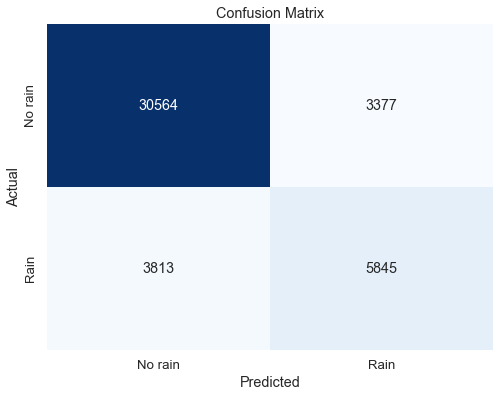

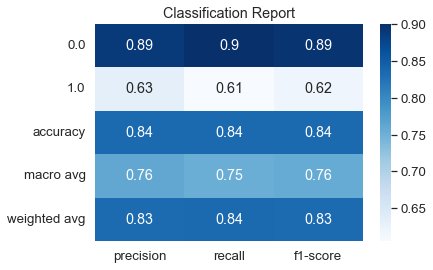

In [27]:
classes = ['No rain', 'Rain']

#Plot confusion matrix
plot_confusion_matrix(y_val, y_predicted, classes, title='Confusion Matrix')


#Classification report
plot_classification_report(y_val, y_predicted, title='Classification Report')

#### ROC curve

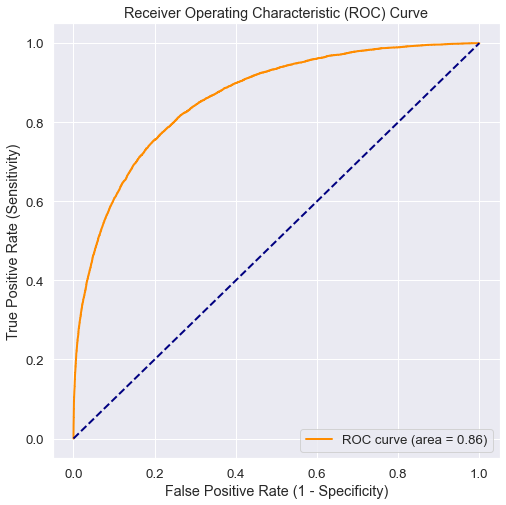

In [28]:
y_probabilities = model.predict_proba(X_sc_val)[:, 1] #Probabilities of positives

fpr, tpr, thresholds = roc_curve(y_sc_val, y_probabilities) #Fail positive rate and true positive rate

roc_auc = auc(fpr, tpr) #Area under ROC curve

#Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<br>
<br>
<br>
<br>
<br>

In [22]:
# Obtener las probabilidades de clase para la clase positiva
y_probabilities = model.predict_proba(X_sc_val)[:, 1]  # Reemplaza 'X_test' con tus datos de prueba

# Definir una serie de umbrales
thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

# Evaluar el rendimiento del modelo para cada umbral
for threshold in thresholds:
    y_predictions = (y_probabilities > threshold).astype(int)
    
    # Calcular y mostrar métricas de rendimiento (por ejemplo, precisión, recall, F1-score)
    precision = precision_score(y_val, y_predictions)
    recall = recall_score(y_val, y_predictions)
    f1 = f1_score(y_val, y_predictions)
    
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

Threshold: 0.20 | Precision: 0.4405 | Recall: 0.8478 | F1-score: 0.5797
Threshold: 0.25 | Precision: 0.4866 | Recall: 0.7907 | F1-score: 0.6024
Threshold: 0.30 | Precision: 0.5301 | Recall: 0.7421 | F1-score: 0.6184
Threshold: 0.35 | Precision: 0.5689 | Recall: 0.6939 | F1-score: 0.6252
Threshold: 0.40 | Precision: 0.6029 | Recall: 0.6471 | F1-score: 0.6242
Threshold: 0.45 | Precision: 0.6338 | Recall: 0.6052 | F1-score: 0.6192
Threshold: 0.50 | Precision: 0.6629 | Recall: 0.5647 | F1-score: 0.6099
Threshold: 0.55 | Precision: 0.6899 | Recall: 0.5244 | F1-score: 0.5959
Threshold: 0.60 | Precision: 0.7173 | Recall: 0.4814 | F1-score: 0.5761
Threshold: 0.65 | Precision: 0.7443 | Recall: 0.4353 | F1-score: 0.5493
Threshold: 0.70 | Precision: 0.7760 | Recall: 0.3928 | F1-score: 0.5216
Threshold: 0.75 | Precision: 0.8079 | Recall: 0.3471 | F1-score: 0.4856
Threshold: 0.80 | Precision: 0.8443 | Recall: 0.2970 | F1-score: 0.4394
Threshold: 0.85 | Precision: 0.8847 | Recall: 0.2359 | F1-score:

#### Best threshold seems to be 0.45

In [23]:
# Obtén las probabilidades predichas
y_pred_proba = model.predict_proba(X_sc_val)[:, 1]

# Aplica tu umbral personalizado (0.45 en este caso)
umbral = 0.45
y_predicted = (y_pred_proba > umbral).astype(int)

<br>
<br>
<br>
<br>
<br>

#### Save model

In [20]:
'''
ubi = r'C:\Users\Lucio\Documents\Github\Next-day-rain-prediction\3- Models/XGBClf_rain_pred.joblib'

joblib.dump(model, ubi)
'''

['C:\\Users\\Lucio\\Documents\\Github\\Next-day-rain-prediction\\3- Models/XGBClf_rain_pred.joblib']